In [84]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline
import os

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os,boto3,sys,glob,json

### Part 1  Loading the  data 

In [2]:
# the data processing and saving the 2000 charts are done in IBCdata_prepare4modeling_April022019.ipynb
#trainDF=pd.read_csv('ibc_trainingdata_040219.csv')  # pd.read_csv('/home/jovyan/work/TinaZ/ibc_trainingdata_040219.csv')
#testDF=pd.read_csv('ibc_testingdata_040219.csv')   #   pd.read_csv('/home/jovyan/work/TinaZ/ibc_testingdata_040219.csv')
#testDF=pd.read_csv('testdata4comp_050619.csv')
testDF=pd.read_csv('./model_comparison/complete_test_1000charts_df_0523.csv')
print(len(testDF))

58286


In [3]:
testDF.columns

Index(['Unnamed: 0', 'chart_id', 'code_id', 'end_offset', 'flag', 'label',
       'start_offset', 'text', 'text75'],
      dtype='object')

In [4]:
testDF.drop(['Unnamed: 0'],inplace=True, axis=1)

In [5]:
testDF.tail()

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75
58281,IBXRMA2018_MULT_1164548890010001_HMK_208365363...,I2510,16651.0,0.0,deleted,16572,atherosclerotic heart disease of native corona...,clusion stenosis unspecified carotid artery i6...
58282,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,30066.0,0.0,deleted,30052,polyneuropathy,time a1c 70 cont treatment dm continue monitor...
58283,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,29722.0,0.0,deleted,29708,polyneuropathy,ith hyperlipidemia controlled cont treatment d...
58284,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,I10,1782.0,0.0,deleted,1779,i10,hronic kidney disease stage iv 184 benign esse...
58285,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,N19,31172.0,0.0,deleted,31155,renal dysfunction,icd1012510 stable angina pectoris icd4139 hype...


In [6]:
testDF['flag'].value_counts()

0.0    33045
1.0    25241
Name: flag, dtype: int64

In [7]:
testDF['label'].value_counts()

deleted    33045
added      16100
agreed      9141
Name: label, dtype: int64

In [8]:
len(testDF)

58286

In [9]:
nulltext=testDF[~pd.notnull(testDF['text'])] 
nulltext.head()

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75


In [10]:
#testDF = testDF[pd.notnull(testDF['text'])] 
#len(testDF)

In [11]:
nulltext=testDF[~pd.notnull(testDF['text75'])] 
nulltext.head()

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75
48942,IBXRMA2018_MULT_1217369820010001_HMK_159307755...,E782,49.0,1.0,added,21,Mixed hyperlipidemia - E78.2,NaN
49619,IBXRMA2018_MULT_1217796040010001_HMK_211221367...,E785,79.0,1.0,added,52,"Hyperlipidemia, unspecified",NaN
49620,IBXRMA2018_MULT_1217796040010001_HMK_211221367...,E785,66.0,1.0,added,52,Hyperlipidemia,NaN


In [12]:
testDF = testDF[pd.notnull(testDF['text75'])] 
len(testDF)

58283

In [13]:
testDF=testDF.reset_index(drop=True)
testDF.tail()

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75
58278,IBXRMA2018_MULT_1164548890010001_HMK_208365363...,I2510,16651.0,0.0,deleted,16572,atherosclerotic heart disease of native corona...,clusion stenosis unspecified carotid artery i6...
58279,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,30066.0,0.0,deleted,30052,polyneuropathy,time a1c 70 cont treatment dm continue monitor...
58280,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,29722.0,0.0,deleted,29708,polyneuropathy,ith hyperlipidemia controlled cont treatment d...
58281,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,I10,1782.0,0.0,deleted,1779,i10,hronic kidney disease stage iv 184 benign esse...
58282,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,N19,31172.0,0.0,deleted,31155,renal dysfunction,icd1012510 stable angina pectoris icd4139 hype...


In [14]:
testDF['chart_id'].nunique()

798

### Part 2 Loading all the models or locate the directory

#### Part 2.a. Load the 28 pickle files and run them on the testDF with selected chart_ids

In [15]:
files=glob.glob("../picklefolder_ngrams/refreshed_models/*.pickle")

In [16]:
files

['../picklefolder_ngrams/refreshed_models/Phrase_stroke_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_emphysema_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_hypertension_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_dementia_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_cholesterol_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_cad_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_aneurysm_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_COPD_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Depression_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Diabetes_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Heart_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Kidney_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Model1_LRApril0219.pi

In [17]:
#files=files[:-1]   # remove the PMH model, only for pipeline folder
len(files)

28

In [18]:
files[1].split('/')[3]

'Phrase_emphysema_LRApril0219.pickle'

In [19]:
files[7].split('/')[3].split('_')[1]

'COPD'

### Part 3. Apply models to test data

In [20]:
encoder = preprocessing.LabelEncoder()
test_y = encoder.fit_transform(testDF['flag'])  

In [21]:
code_list={}
code_list["Model1"]=['I10','E119']
code_list["Model2"]=['I2510','E785','K219','F329','I639']
code_list["Model3"]=['I739','N183','Z992','B20','I213','R569','I43','J410','I714','R579','E550','I209','J45998','I480','B182','K210','K739']
code_list["Heart"]=['I509','I482','I4891','I82401']
code_list["Depression"]=['F411','F410','F40240','F458','F409','F4000','F4001','F445','F444','F40243','F446','F4010','F442','F408','F449','F451']
code_list["Kidney"]=['N189','N181','N182','E1122','I130','E0822','E1022']
code_list["Diabetes"]=['Z794','E109','E119','E139','E089','E099']
code_list["Cancer"]=['C801','C50919','C189']
code_list["COPD"]=['J449','J45909']
code_list["Cholesterol"]=['E780','E785','E782','E789','E7800','E784','E781','E7801','E7881','E882','E783','E786','E7889','E756','E755','E7130']

In [22]:
allpredict=pd.DataFrame()   # create an empty dataframe, to save the prediction result for each model
allprob=pd.DataFrame()
print(allpredict)

Empty DataFrame
Columns: []
Index: []


In [23]:
f = open("refreshedmodeltestscore_0524.txt", "w+")  # save all the score to this file


for i in range(len(files)):
    indexdf=pd.DataFrame()    # create a dataframe, otherwise can use testDF for merging to obtain the prediction matched to index
# because for some model testing, we only select partial data, like phrase-based model, code-based model
    model_pipeline = joblib.load(files[i])
    f = open("refreshedmodeltestscore_0524.txt", "a+")
    # deletion model
    if(files[i].split('/')[3].startswith('D')):
        try:
            testDF1=testDF   # no selection, run for all instances
            indexdf[i]= [1 for i in range(len(testDF))]
        except:
            print('no data for this model')
        
    elif(files[i].split('/')[3].startswith('P')):
    # if it's phrase-based model, use the following way to select data
        
        phrase=files[i].split('/')[3].split('_')[1]
        try:
            testDF1 = testDF[testDF['text'].str.contains(phrase,flags=re.IGNORECASE)]
            temp=testDF1.index.tolist()
            indexdf[i]=[1 if i in (temp) else 0 for i in range(len(testDF))]
        except:
            print('no data for this model')

    elif(files[i].split('/')[3].startswith('C')):
    # if it's code based model, use the following way to select model
        codereason=files[i].split('/')[3].split('_')[1]
        try:
            testDF1 = testDF[testDF['code_id'].isin(code_list[codereason])]
            temp=testDF1.index.tolist()
            indexdf[i]=[1 if i in (temp) else 0 for i in range(len(testDF))]
        except:
            print('no data for this model')
    else:
        print('not a valid/good model name probably...')

    #print(files[i])
    # how to put the prediction on the right index?
    try:
        test=testDF1['text75']
        prediction = model_pipeline.predict(test)
        proba = model_pipeline.predict_proba(test)[:,1]
        
        testDF1['key']=testDF1.index
        testDF1['pred']=prediction
        testDF1['prob']= proba

        indexdf['key']=indexdf.index
        merged=pd.merge(indexdf,testDF1,on='key',how='outer')  # maintain the position of the perdiction, match to the right index
        allpredict[i]=merged['pred']    # save the prediction to corresponding dataframe
        allprob[i]=merged['prob']   # save the probability

        # the following just generate accuracy report for each model
        conf_mat = confusion_matrix(testDF1['flag'], (1-prediction))
        df_cm = pd.DataFrame(conf_mat, range(2),
                      range(2))
        tn, fp, fn, tp = conf_mat.ravel()
        report = classification_report(testDF1['flag'], (1-prediction))
        lines = report.split('\n')
        #print(lines[2])
        row_data = lines[3].split('     ')
        print("testing model:",(files[i]))
        print("accuracy_score  precision recall  f1_score tn  fn  fp  tp")
        print(accuracy_score(testDF1['flag'],(1-prediction)),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp) 

        f.write("testing model: %s\n" % files[i])
        f.write("accuracy_score  precision recall f1_score tn  fn  fp  tp\n")
        f.write("%f %f %f %f %f %f %f %f \n" % (accuracy_score(testDF1['flag'],(1-prediction)),float(row_data[2]),float(row_data[3]),float(row_data[4]), tn, fn, fp, tp))
        f.write("..............................\n")
    except:
        print('something is wrong in the above process')
#print(allpredict)
#f.close()

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_stroke_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.985714285714   0.00  0.00  0.00 138 2 0 0
testing model: ../picklefolder_ngrams/refreshed_models/Phrase_emphysema_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.677215189873   0.57  0.86  0.68 52 9 42 55


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_hypertension_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.748815165877   0.73  1.00  0.84 507 16 1415 3759


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_dementia_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.697222222222   0.55  0.92  0.69 130 11 98 121


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_cholesterol_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.814047909054   0.53  0.94  0.68 1529 30 428 476


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_cad_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.786868686869   0.59  0.89  0.71 521 33 178 258


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_aneurysm_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.812636165577   0.62  0.84  0.71 267 20 66 106


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_COPD_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.731631382316   0.72  0.93  0.81 264 72 359 911


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Depression_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.849256900212   0.42  0.88  0.57 707 13 129 93


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Diabetes_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.786102484472   0.58  0.85  0.69 2837 221 881 1213


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Heart_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.750670241287   0.58  0.87  0.70 1044 91 467 636


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Kidney_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.658476658477   0.62  0.86  0.72 177 57 221 359


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Model1_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.742946450605   0.68  0.96  0.79 2976 253 2872 6056


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Cancer_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.925522252498   0.49  0.76  0.60 958 19 63 61


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Cholesterol_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.790971113369   0.75  0.98  0.85 1495 87 1353 3954


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Model2_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.786014781126   0.76  0.95  0.84 1855 247 1635 5058


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your 

testing model: ../picklefolder_ngrams/refreshed_models/Code_Model3_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.831700413673   0.67  0.96  0.79 2405 64 709 1415


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_asthma_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.657672849916   0.57  0.98  0.72 127 5 198 263


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_cancer_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.897321428571   0.34  0.61  0.44 1345 39 122 62


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_ckd_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.602870813397   0.56  1.00  0.72 42 1 165 210


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_depression_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.852090032154   0.61  0.76  0.67 870 60 124 190


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/Phrase_diabetes_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.743117010816   0.63  0.95  0.75 1422 88 957 1601


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_family_history_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.477137415713   0.45  1.00  0.62 2608 37 30437 25201


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_negation_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.511727261809   0.47  1.00  0.64 4667 80 28378 25158


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_not_doctors_note_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.538407425836   0.48  0.99  0.65 6277 135 26768 25103


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_not_relevant_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.639037112022   0.55  0.98  0.70 12460 453 20585 24785


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_phoneORaddressORother_number_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.458487037387   0.44  1.00  0.62 1489 5 31556 25233


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your ow

testing model: ../picklefolder_ngrams/refreshed_models/DeletionReason_preventative_screening_LRApril0219.pickle
accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.48307396668   0.46  1.00  0.63 3000 83 30045 25155


####  Part 2.b. Now get the prediction and probability dataframes and merge with testDF which has all the chart_id etc info

In [24]:
allpredict.isnull().sum()  # a lot of nulls because not all data are run for each model, but for deletion model, all are run

0     58143
1     58125
2     52586
3     57923
4     55820
5     57293
6     57824
7     56677
8     57341
9     53131
10    56045
11    57469
12    46126
13    57182
14    51394
15    49488
16    53690
17    57690
18    56715
19    57865
20    57039
21    54215
22        0
23        0
24        0
25        0
26        0
27        0
dtype: int64

In [25]:
allpredict.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [26]:
allprob.head() #QC

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,NaN,NaN,0.113764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.008170,0.036722,0.046403,0.221087,0.024644,0.018220
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.013850,0.058010,0.056316,0.126772,0.586640,0.031730
2,NaN,NaN,0.095343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001922,0.005785,0.002761,0.027563,0.000697,0.002077
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.011222,0.090504,0.011301,0.079710,0.044617,0.005878
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.010372,0.049678,0.042067,0.182428,0.468713,0.018043


In [27]:
len(allpredict)

58283

In [28]:
len(testDF)

58283

In [29]:
# the data frame for predictions from each model
#merge to testDF to keep the Nan, which means not omputed for that instance
#testDF2=pd.concat([testDF,allpredict],axis=1)
#len(testDF2)
testDF['index']=testDF.index
allpredict['index']=allpredict.index
df_pred = pd.merge(testDF,allpredict, how='left', on = 'index')
len(df_pred)

58283

In [30]:
df_pred.tail()

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75,key,pred,...,18,19,20,21,22,23,24,25,26,27
58278,IBXRMA2018_MULT_1164548890010001_HMK_208365363...,I2510,16651.0,0.0,deleted,16572,atherosclerotic heart disease of native corona...,clusion stenosis unspecified carotid artery i6...,58278,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
58279,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,30066.0,0.0,deleted,30052,polyneuropathy,time a1c 70 cont treatment dm continue monitor...,58279,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
58280,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,29722.0,0.0,deleted,29708,polyneuropathy,ith hyperlipidemia controlled cont treatment d...,58280,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
58281,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,I10,1782.0,0.0,deleted,1779,i10,hronic kidney disease stage iv 184 benign esse...,58281,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
58282,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,N19,31172.0,0.0,deleted,31155,renal dysfunction,icd1012510 stable angina pectoris icd4139 hype...,58282,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [31]:
# now the data frame with probabilities
testDF['index']=testDF.index
allprob['index']=allprob.index
df_prob = pd.merge(testDF,allprob, how='left', on = 'index')
print(len(df_prob))

58283


#### Part 2.c. Now combine the prediction from 28 models to make one prediction,it's actually an or operation, but here using sum()

In [32]:
allprob.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,index
0,NaN,NaN,0.113764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.008170,0.036722,0.046403,0.221087,0.024644,0.018220,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.013850,0.058010,0.056316,0.126772,0.586640,0.031730,1
2,NaN,NaN,0.095343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001922,0.005785,0.002761,0.027563,0.000697,0.002077,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.011222,0.090504,0.011301,0.079710,0.044617,0.005878,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.010372,0.049678,0.042067,0.182428,0.468713,0.018043,4


In [33]:
allpredictNan=allpredict   # keep the original NaN if that row is not computed for that model
allpredict=allpredict.fillna(0) # fill the NaNs by zero , for computation I need to fill Nan to a number 0 

In [34]:
allpredictNan.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,index
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,4


In [35]:
#allpredict=allpredictNan
#allpredict=allpredict.fillna(0)
allpredict.drop(['index'],inplace=True, axis=1)  # need to drop this column
allpredict.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [36]:
# sum across the row and if any is greater than 0, it's a deletion
# important, this is how I combine prediction from each model and give the one prediction

allpredict['Sum'] = allpredict.sum(axis = 1, skipna = True) 
df_pred['all_model_pred']=[1 if allpredict['Sum'].iloc[i]>=1 else 0 for i in range(len(allpredict))] 

In [37]:
# check how many 1s are predicted 
allpredict1=df_pred['all_model_pred']
print(sum(allpredict1))  # predicted as delete
print(len(allpredict1))  #  total instances

22753
58283


In [38]:
# if drop column 19 which is deletion_phone model, see if it can improve accuracy

In [39]:
df_pred.tail()  
#all_model_pred is check any model output is 1 for that instance

,chart_id,code_id,end_offset,flag,label,start_offset,text,text75,key,pred,...,19,20,21,22,23,24,25,26,27,all_model_pred
58278,IBXRMA2018_MULT_1164548890010001_HMK_208365363...,I2510,16651.0,0.0,deleted,16572,atherosclerotic heart disease of native corona...,clusion stenosis unspecified carotid artery i6...,58278,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
58279,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,30066.0,0.0,deleted,30052,polyneuropathy,time a1c 70 cont treatment dm continue monitor...,58279,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
58280,IBXRMA2018_MULT_1216744910010001_HMK_135268510...,G629,29722.0,0.0,deleted,29708,polyneuropathy,ith hyperlipidemia controlled cont treatment d...,58280,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
58281,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,I10,1782.0,0.0,deleted,1779,i10,hronic kidney disease stage iv 184 benign esse...,58281,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
58282,IBXRMA2018_MULT_1197832420010001_HMK_8TF2T50JY...,N19,31172.0,0.0,deleted,31155,renal dysfunction,icd1012510 stable angina pectoris icd4139 hype...,58282,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0


#### Change the columns names from number to the correponding model name

In [40]:
df_prob.columns

Index([    'chart_id',      'code_id',   'end_offset',         'flag',
              'label', 'start_offset',         'text',       'text75',
                'key',         'pred',         'prob',        'index',
                    0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,             27],
      dtype='object')

In [41]:
# drop the key and predict prob temp columns
df_pred.drop(['key','pred','prob'],inplace=True, axis=1)
df_prob.drop(['key','pred','prob'],inplace=True, axis=1)

In [42]:
files

['../picklefolder_ngrams/refreshed_models/Phrase_stroke_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_emphysema_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_hypertension_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_dementia_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_cholesterol_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_cad_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Phrase_aneurysm_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_COPD_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Depression_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Diabetes_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Heart_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Kidney_LRApril0219.pickle',
 '../picklefolder_ngrams/refreshed_models/Code_Model1_LRApril0219.pi

In [43]:
# rename the number columns to columns names

col_dict = {0: 'Phrase_stroke', 1: 'Phrase_emphysema',2:'Phrase_hypertension',3:'Phrase_dementia',4:'Phrase_cholesterol',
           5:'Phrase_cad',6:'Phrase_aneurysm',7:'Code_COPD',8:'Code_Depression',9:'Code_Diabetes',10:'Code_Heart',
           11:'Code_Kidney',12:'Code_Model1',13:'Code_Cancer',14:'Code_Cholesterol',15:'Code_Model2',
           16:'Code_Model3',17:'Phrase_asthma',18:'Phrase_cancer',19:'Phrase_ckd',20:'Phrase_depression',21:'Phrase_diabetes',
            22:'DeletionReason_family_history',23:'DeletionReason_negation',24:'DeletionReason_not_doctors_note',
           25:'DeletionReason_not_relevant',26:'DeletionReason_phoneORaddressORother_number',27:'DeletionReason_preventative_screening'
           }   ## key→old name, value→new name

df_pred.columns = [col_dict.get(x, x) for x in df_pred.columns]
df_prob.columns = [col_dict.get(x, x) for x in df_prob.columns]

In [85]:
df_pred.columns

Index(['chart_id', 'code_id', 'end_offset', 'flag', 'label', 'start_offset',
       'text', 'text75', 'index', 'Phrase_stroke', 'Phrase_emphysema',
       'Phrase_hypertension', 'Phrase_dementia', 'Phrase_cholesterol',
       'Phrase_cad', 'Phrase_aneurysm', 'Code_COPD', 'Code_Depression',
       'Code_Diabetes', 'Code_Heart', 'Code_Kidney', 'Code_Model1',
       'Code_Cancer', 'Code_Cholesterol', 'Code_Model2', 'Code_Model3',
       'Phrase_asthma', 'Phrase_cancer', 'Phrase_ckd', 'Phrase_depression',
       'Phrase_diabetes', 'DeletionReason_family_history',
       'DeletionReason_negation', 'DeletionReason_not_doctors_note',
       'DeletionReason_not_relevant',
       'DeletionReason_phoneORaddressORother_number',
       'DeletionReason_preventative_screening', 'all_model_pred'],
      dtype='object')

In [86]:
df_pred['DeletionReason_family_history'].nunique()

2

In [87]:
df_pred['DeletionReason_family_history'].value_counts()

0    55638
1     2645
Name: DeletionReason_family_history, dtype: int64

In [98]:
len(df_pred[df_pred['text75'].str.contains('family history',flags=re.IGNORECASE)])

1773

In [102]:
#selectkeep_drfamhis=df_pred[df_pred['DeletionReason_family_history']==0]
#print(len(selectkeep_drfamhis[selectkeep_drfamhis['text75'].str.contains('family history',flags=re.IGNORECASE)]))

391


In [101]:
#select_drfamhis=df_pred[df_pred['DeletionReason_family_history']==1]
#len(select_drfamhis)

2645

In [100]:
#len(select_drfamhis[select_drfamhis['text75'].str.contains('family history',flags=re.IGNORECASE)])

1382

In [95]:
#select_drfamhis['text75'].iloc[100]

'rrhoidectomy colonoscopy 2015 family history mother deceased 53 yrs chronic obstructive pulmonary disease father deceased 79 yrs chronic obstructive pulmonary disease coronary'

In [92]:
#select_drfamhis.to_csv('predictedexample_familyhistory.csv')

In [45]:
df_prob.columns

Index(['chart_id', 'code_id', 'end_offset', 'flag', 'label', 'start_offset',
       'text', 'text75', 'index', 'Phrase_stroke', 'Phrase_emphysema',
       'Phrase_hypertension', 'Phrase_dementia', 'Phrase_cholesterol',
       'Phrase_cad', 'Phrase_aneurysm', 'Code_COPD', 'Code_Depression',
       'Code_Diabetes', 'Code_Heart', 'Code_Kidney', 'Code_Model1',
       'Code_Cancer', 'Code_Cholesterol', 'Code_Model2', 'Code_Model3',
       'Phrase_asthma', 'Phrase_cancer', 'Phrase_ckd', 'Phrase_depression',
       'Phrase_diabetes', 'DeletionReason_family_history',
       'DeletionReason_negation', 'DeletionReason_not_doctors_note',
       'DeletionReason_not_relevant',
       'DeletionReason_phoneORaddressORother_number',
       'DeletionReason_preventative_screening'],
      dtype='object')

#### change the columns names and also compare the probability and prediction to see if they match

In [46]:
#df_pred.rename(columns={'start': 'start_offset', 'end': 'end_offset'}, inplace=True)

In [47]:
df_pred[['chart_id','start_offset','end_offset','DeletionReason_phoneORaddressORother_number']].head()

,chart_id,start_offset,end_offset,DeletionReason_phoneORaddressORother_number
0,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,1391,1403.0,0
1,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,3817,3819.0,1
2,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,13537,13549.0,0
3,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,14636,14639.0,0
4,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,14723,14725.0,0


In [48]:
#df_prob.rename(columns={'start': 'start_offset', 'end': 'end_offset'}, inplace=True)
df_prob[['chart_id','start_offset','end_offset','DeletionReason_phoneORaddressORother_number']].head()  #ok make sense

,chart_id,start_offset,end_offset,DeletionReason_phoneORaddressORother_number
0,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,1391,1403.0,0.024644
1,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,3817,3819.0,0.586640
2,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,13537,13549.0,0.000697
3,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,14636,14639.0,0.044617
4,IBXRMA2018_MULT_1163297620010001_HMK_179342168...,14723,14725.0,0.468713


In [49]:
print(len(set(df_pred['chart_id'].tolist())))
print(len(set(df_prob['chart_id'].tolist())))   # 813 unique chart ids

798
798


### Part 4. Compare with pipeline feedback and do some tweak and compare again

In [50]:
df_pred['label'].value_counts()

deleted    33045
added      16097
agreed      9141
Name: label, dtype: int64

In [51]:
df_pred['flag'].value_counts()  # 1 is agree+added 0 is deletion  for true values

0.0    33045
1.0    25238
Name: flag, dtype: int64

In [52]:
df_pred['all_model_pred'].value_counts()  # perdicted 0 is agree, 1 is deletion. so need to reverse below

0    35530
1    22753
Name: all_model_pred, dtype: int64

In [54]:
df_pred.to_csv('refreshed_allmodel_pred_withcoder_0527.csv')

Test accuracy is 0.7659694936774016
              precision    recall  f1-score   support

         0.0       0.93      0.64      0.76     33045
         1.0       0.66      0.93      0.78     25238

   micro avg       0.77      0.77      0.77     58283
   macro avg       0.79      0.79      0.77     58283
weighted avg       0.81      0.77      0.76     58283

accuracy_score  precision recall  f1_score tn  fn  fp  tp
0.765969493677   0.66  0.93  0.78 21079 1674 11966 23564


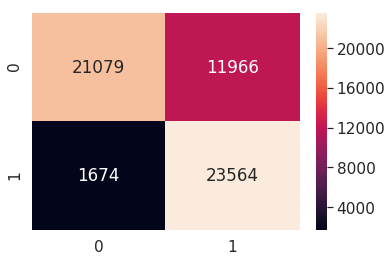

In [53]:
# 
print('Test accuracy is {}'.format(accuracy_score(df_pred['flag'], (1-df_pred['all_model_pred']))))
conf_mat = confusion_matrix(df_pred['flag'], (1-df_pred['all_model_pred']))
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(df_pred['flag'],(1-df_pred['all_model_pred'])))


#conf_mat = confusion_matrix(test_y, allpredict1)
tn, fp, fn, tp = conf_mat.ravel()
report = classification_report(df_pred['flag'], (1-df_pred['all_model_pred']))
lines = report.split('\n')
    #print(lines[2])
row_data = lines[3].split('     ')
print("accuracy_score  precision recall  f1_score tn  fn  fp  tp")
print(accuracy_score(df_pred['flag'], (1-df_pred['all_model_pred'])),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

f = open("refreshedmodeltestscore_0524.txt", "a+")
f.write("..............................\n")
f.write("Combine 28 models accuracy score:\n")
f.write("accuracy_score  precision recall f1_score tn  fn  fp  tp\n")
f.write("%f %f %f %f %f %f %f %f \n" % (accuracy_score(df_pred['flag'],(1-df_pred['all_model_pred'])),float(row_data[2]),float(row_data[3]),float(row_data[4]), tn, fn, fp, tp))
f.write("..............................\n")   

f.close()

### Part 5 Not very related section: Checking on text where the text is the code, and see how many add/agreed/deleted

In [55]:
df_pred['text'].nunique()

5622

In [ ]:
code_list={}
code_list["Model1"]=['I10','E119']
code_list["Model2"]=['I2510','E785','K219','F329','I639']
code_list["Model3"]=['I739','N183','Z992','B20','I213','R569','I43','J410','I714','R579','E550','I209','J45998','I480','B182','K210','K739']
code_list["Heart"]=['I509','I482','I4891','I82401']
code_list["Depression"]=['F411','F410','F40240','F458','F409','F4000','F4001','F445','F444','F40243','F446','F4010','F442','F408','F449','F451']
code_list["Kidney"]=['N189','N181','N182','E1122','I130','E0822','E1022']
code_list["Diabetes"]=['Z794','E109','E119','E139','E089','E099']
code_list["Cancer"]=['C801','C50919','C189']
code_list["COPD"]=['J449','J45909']
code_list["Cholesterol"]=['E780','E785','E782','E789','E7800','E784','E781','E7801','E7881','E882','E783','E786','E7889','E756','E755','E7130']

In [73]:
# put all code in one list
# getting list of all codes from code_list dict
from functools import reduce
code_id_list=[]
for key in code_list.keys():
    code_id_list.append(code_list[key])
code_id_list = reduce(lambda x,y: x+y,code_id_list)
print (code_id_list)
print ('total code ids : ',len(code_id_list)) 

['I10', 'E119', 'I2510', 'E785', 'K219', 'F329', 'I639', 'I739', 'N183', 'Z992', 'B20', 'I213', 'R569', 'I43', 'J410', 'I714', 'R579', 'E550', 'I209', 'J45998', 'I480', 'B182', 'K210', 'K739', 'I509', 'I482', 'I4891', 'I82401', 'F411', 'F410', 'F40240', 'F458', 'F409', 'F4000', 'F4001', 'F445', 'F444', 'F40243', 'F446', 'F4010', 'F442', 'F408', 'F449', 'F451', 'N189', 'N181', 'N182', 'E1122', 'I130', 'E0822', 'E1022', 'Z794', 'E109', 'E119', 'E139', 'E089', 'E099', 'C801', 'C50919', 'C189', 'J449', 'J45909', 'E780', 'E785', 'E782', 'E789', 'E7800', 'E784', 'E781', 'E7801', 'E7881', 'E882', 'E783', 'E786', 'E7889', 'E756', 'E755', 'E7130']
total code ids :  78


In [67]:
code_id_list2= [x.lower() for x in code_id_list]
print(code_id_list2)

['i10', 'e119', 'i2510', 'e785', 'k219', 'f329', 'i639', 'i739', 'n183', 'z992', 'b20', 'i213', 'r569', 'i43', 'j410', 'i714', 'r579', 'e550', 'i209', 'j45998', 'i480', 'b182', 'k210', 'k739', 'i509', 'i482', 'i4891', 'i82401', 'f411', 'f410', 'f40240', 'f458', 'f409', 'f4000', 'f4001', 'f445', 'f444', 'f40243', 'f446', 'f4010', 'f442', 'f408', 'f449', 'f451', 'n189', 'n181', 'n182', 'e1122', 'i130', 'e0822', 'e1022', 'z794', 'e109', 'e119', 'e139', 'e089', 'e099', 'c801', 'c50919', 'c189', 'j449', 'j45909', 'e780', 'e785', 'e782', 'e789', 'e7800', 'e784', 'e781', 'e7801', 'e7881', 'e882', 'e783', 'e786', 'e7889', 'e756', 'e755', 'e7130']


In [74]:
code_id_list.extend(code_id_list2)
print(code_id_list)

['I10', 'E119', 'I2510', 'E785', 'K219', 'F329', 'I639', 'I739', 'N183', 'Z992', 'B20', 'I213', 'R569', 'I43', 'J410', 'I714', 'R579', 'E550', 'I209', 'J45998', 'I480', 'B182', 'K210', 'K739', 'I509', 'I482', 'I4891', 'I82401', 'F411', 'F410', 'F40240', 'F458', 'F409', 'F4000', 'F4001', 'F445', 'F444', 'F40243', 'F446', 'F4010', 'F442', 'F408', 'F449', 'F451', 'N189', 'N181', 'N182', 'E1122', 'I130', 'E0822', 'E1022', 'Z794', 'E109', 'E119', 'E139', 'E089', 'E099', 'C801', 'C50919', 'C189', 'J449', 'J45909', 'E780', 'E785', 'E782', 'E789', 'E7800', 'E784', 'E781', 'E7801', 'E7881', 'E882', 'E783', 'E786', 'E7889', 'E756', 'E755', 'E7130', 'i10', 'e119', 'i2510', 'e785', 'k219', 'f329', 'i639', 'i739', 'n183', 'z992', 'b20', 'i213', 'r569', 'i43', 'j410', 'i714', 'r579', 'e550', 'i209', 'j45998', 'i480', 'b182', 'k210', 'k739', 'i509', 'i482', 'i4891', 'i82401', 'f411', 'f410', 'f40240', 'f458', 'f409', 'f4000', 'f4001', 'f445', 'f444', 'f40243', 'f446', 'f4010', 'f442', 'f408', 'f449',

In [75]:
# now select those with the above code ids in the text
print(len(df_pred))
select_df_pred=df_pred[df_pred['text'].isin(code_id_list)==True]
print(len(select_df_pred))

58283
662


In [76]:
select_df_pred['label'].value_counts()

agreed     382
added      207
deleted     73
Name: label, dtype: int64

In [77]:
# now use 6000 charts with coder feedback data
codeoutput=pd.read_csv('/home/jovyan/work/Analytics_Data_training/conditions_with_chartids_29042019.csv')

In [78]:
codeoutput.columns

Index(['Unnamed: 0', 'chart_id', 'created_at', 'submission_id', 'user_id',
       'code_id', 'diagnosis_id', 'isActive', 'status', 'ai', 'annotation_id',
       'deleted', 'deleted_reason', 'end', 'evidence', 'selectedText', 'start',
       'text', '75bef', '75aft', '25wordsbef', '25wordsaft', 'label', 'flag'],
      dtype='object')

In [79]:
print(len(codeoutput))

136527


In [81]:
codeoutput['label'].value_counts()

added      79814
agreed     41794
deleted    14919
Name: label, dtype: int64

In [82]:
select_6000df_pred=codeoutput[codeoutput['text'].isin(code_id_list)==True]
print(len(select_6000df_pred))

3333


In [83]:
select_6000df_pred['label'].value_counts()

agreed     1833
added      1015
deleted     485
Name: label, dtype: int64